# Project: YOLOv5-Based Fracture Detection Application

## Purpose of Project

In this project I would like to build a application about training a YOLOv5 model to detect fractures using a Kaggle dataset and later integrating an LLM to provide non-medical suggestions.

## Dataset Introduction

In my project, I use [XR-bones Dataset for Bone Fracture Detection](https://www.kaggle.com/datasets/japeralrashid/xr-bones-dataset-for-bone-fracture-detection/data) dataset to train my deep neural network algorithm.

The XR-bones dataset is a comprehensive collection of X-ray images designed to facilitate research and development in bone fracture detection using computer vision techniques. This dataset contains X-ray images categorized into two main classes: negative (no fracture) and positive (fracture present). The data is further organized by specific anatomical regions, ensuring a diverse and detailed representation of bone fractures.

The XR-bones dataset is ideal for developing and evaluating automated bone fracture detection algorithms. Potential applications include:

- **Medical Diagnostics**: Assisting radiologists in detecting fractures quickly and accurately.
- **Research**: Facilitating research in computer vision, deep learning, and medical image analysis.
- **Education**: Serving as a valuable resource for educational purposes in medical and technological fields.

This dataset has two sub folders:

- `images`: All medical images containing fractures and non-fractures.
- - `train`: Training images in `png` extension with `23581` photos.
- - `val`: Validation images in `png` extension with `1000` photos.
- `labels`: All labels in `txt` files that generated from YOLO model format.
- - `train`: Training labels in `txt` extension with `23581` files.
- - `val`: Validation images in `txt` extension with `1000` files.

The train folder is the main dataset for model training. In addition to the main dataset, a validation set is provided to evaluate model performance. The validation set includes 1000 images along with their corresponding labels and bounding box annotations.

Each txt file contains the following information for the respective images:

- Image ID: A unique identifier for each image.
- Class Label: Indicates whether the image is classified as negative (0) or positive (1).
- Bounding Box Coordinates: The coordinates (x_min, y_min, x_max, y_max) of the bounding box surrounding the fracture area.

## What Features Do I Have?

The dataset is divided into the following categories:

| Negative Classes (No Fracture) | Positive Classes (Fracture Present) |
| ------------------------------ | ----------------------------------- |
| XR_ELBOW_negative              | XR_ELBOW_positive                   |
| XR_FINGER_negative             | XR_FINGER_positive                  |
| XR_FOREARM_negative            | XR_FOREARM_positive                 |
| XR_HAND_negative               | XR_HAND_positive                    |
| XR_SHOULDER_negative           | XR_SHOULDER_positive                |

But the distribution of above categories is imbalance, so I decide to combine the classes into two categories:

1. Negative Classes (No Fracture)
2. Positive Classes (Fracture Present)


## Which Model Do I Choose To Train?

In this project, [YOLOv5](https://github.com/ultralytics/yolov5?tab=readme-ov-file) from [ultralytics](https://github.com/ultralytics) package was chosen as the model for fracture detection due to its ease of use for custom dataset training. YOLOv5 offers several advantages:
1. Lightweight architecture that ensures faster inference speeds, which is crucial for real-time applications.
2. Coming with pre-trained weights, allowing for efficient transfer learning.
3. Its active community and extensive documentation provide robust support for troubleshooting and customization.

However, YOLOv5 also has its limitations. Its performance may depend heavily on the quality and quantity of the dataset, requiring careful preprocessing and balancing. Additionally, the model's simplicity might not be optimal for extremely complex datasets compared to more advanced architectures like YOLOv7 or other Transformer-based models.

The decision to start with YOLOv5 is also based on a strategy of iterative improvement. By beginning with a smaller, efficient model, we aim to establish a robust baseline for performance. If further optimization is needed to achieve the target accuracy of 90%, I can progressively transition to larger or more advanced models within the YOLO family or explore alternative architectures. This approach ensures that resources are used effectively, balancing computational efficiency with the need for model accuracy.

<img src="https://raw.githubusercontent.com/ultralytics/assets/refs/heads/main/yolo/performance-comparison.png" style="max-width: 80%; max-height: 100%;">

## What Metrics Do I Choose For Evaluation?

This is a classification problem, therefore, my expected goal is to achieve an accuracy of more than 90 through fine-tuning of the model.


## How Do I Complete This Project?

1. Download the Dataset: Ensure you have sufficient storage space and a reliable internet connection.
2. Extract the Files: Unzip the downloaded files to access the images and CSV annotations.
3. Load the Data: Use appropriate data loading techniques to read the images and annotations into your machine learning pipeline.
4. Train and Evaluate Models: Utilize the dataset to train and evaluate bone fracture detection models using techniques such as Convolutional Neural Networks (CNNs) and other machine learning algorithms.

# Import libraries

In [ ]:
from pathlib import Path

IN_COLAB = True
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  ROOT_DIR = Path('/content/drive/MyDrive/Colab Notebooks/FracAtlas')
else:
  ROOT_DIR = Path('C:/Users/User/Downloads/FracAtlas')

import cv2
import random
import shutil
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Set

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data Analysis (EDA)

First, I have to be one with my data, so I will visualize my dataset to check out the distribution of training and validation data, the format of labels for further custom training.

In this part, I will analyze the dataset from different angles, using multi-class classification and binary classification data to explore the data, and train each to compare the differences in the models.

## Calculate distribution of labels

In th first part, I will count the distribution of labels, this contains the following step:

1. Collect all the paths for images containing no fracture and fracture.

2. Load all the labels that match the image in step 1, most names of image and label are same, I need to filter the unmatched file name.

The YOLO model accepts the label format like:

<img src="https://doimages.nyc3.cdn.digitaloceanspaces.com/010AI-ML/content/images/2021/03/image-26.png" style="max-width: 80%; max-height: 100%;">

The specification for each file like following:

- One row per object
- Each row is class x_center y_center width height format.
- Box coordinates must be normalized by the dimensions of the image (i.e. have values between 0 and 1)
- Class numbers are zero-indexed (start from 0).

I have to visualize them to check out the distribution using matplotlib package.

## Collect Original Image And Labels

In [7]:
# Read original FracAtlas dataset to further separation for fracture detection
FRACTURED_DIR = ROOT_DIR.joinpath('images', 'Fractured')
NORMAL_DIR = ROOT_DIR.joinpath('images', 'Non_fractured')
LABEL_DIR = ROOT_DIR.joinpath('Annotations', 'YOLO')

def generate_label_path(image_path: List) -> Path:
    """
    Generate the corresponding label path for a given image path.
    """
    file_name = str(image_path.name).replace('.jpg', '.txt')
    return Path(str(image_path).split('images')[0]).joinpath('Annotations', 'YOLO', file_name)

# Collect all images
fracture_image_paths = [imgPath for imgPath in FRACTURED_DIR.glob('*.jpg')]
normal_image_paths = [imgPath for imgPath in NORMAL_DIR.glob('*.jpg')]

fracture_image_paths[:5], len(fracture_image_paths), normal_image_paths[:5], len(normal_image_paths)

([PosixPath('/content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0002583.jpg'),
  PosixPath('/content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0002587.jpg'),
  PosixPath('/content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0002593.jpg'),
  PosixPath('/content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0002594.jpg'),
  PosixPath('/content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0002387.jpg')],
 717,
 [PosixPath('/content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Non_fractured/IMG0002779.jpg'),
  PosixPath('/content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Non_fractured/IMG0002778.jpg'),
  PosixPath('/content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Non_fractured/IMG0002780.jpg'),
  PosixPath('/content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Non_fractured/IMG0002781.jpg'),
  PosixPath('/content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Non_fractured/IMG0002788.jpg')],
 3

In [8]:
def read_image(image_path: Path) -> np.array:
    """Read the image using OpenCV"""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # image = cv2.resize(image, (256, 256))

    return image

def calculate_bounding_box(img_height: int, img_width: int, x_center: float, y_center: float, width: float, height: float) -> Tuple:
    """
    Convert normalized bounding box coordinates to pixel coordinates.

    Args:
        img_height: The height of the image in pixels.
        img_width: The width of the image in pixels.
        x_center: The normalized x-coordinate of the box center (0 to 1).
        y_center: The normalized y-coordinate of the box center (0 to 1).
        width: The normalized width of the box (0 to 1).
        height: The normalized height of the box (0 to 1).

    Returns:
        tuple: Bounding box pixel coordinates as (x_min, y_min, x_max, y_max).
    """
    x_center_px = int(x_center * img_width)
    y_center_px = int(y_center * img_height)
    box_width_px = int(width * img_width)
    box_height_px = int(height * img_height)

    x_min = x_center_px - box_width_px // 2
    y_min = y_center_px - box_height_px // 2
    x_max = x_center_px + box_width_px // 2
    y_max = y_center_px + box_height_px // 2

    return x_min, y_min, x_max, y_max

def read_label(label_path: str) -> List:
    rectangles = []

    # read_path
    with open(label_path, 'r') as file:
        lines = file.readlines()

    # calculate rectangles
    for line in lines:
        line = line.strip().split()
        line = map(float, line[1:])
        x_center, y_center, width, height = line
        rectangles.append((x_center, y_center, width, height))

    return rectangles


In [9]:
# Test
rand_img_path = random.choice(fracture_image_paths)
image = read_image(rand_img_path)
img_height, img_width, _ = image.shape

rand_label_path = generate_label_path(rand_img_path)
print(rand_label_path)
rectangles = read_label(rand_label_path)
for rec in rectangles:
    x_center, y_center, width, height = rec
    x_min, y_min, x_max, y_max = calculate_bounding_box(img_height, img_width, x_center, y_center, width, height)
    print(x_min, y_min, x_max, y_max)

/content/drive/MyDrive/Colab Notebooks/FracAtlas/Annotations/YOLO/IMG0002429.txt
152 142 180 196


## Images Visualization

After loading all the images and labels I have to calculate the distribution of labels and visualize the images that contain no fracture and fracture.

In [10]:
def plot_multiple_images_with_rectangles(
        image_paths: List,
        class_title: List = 'fracture',
        figsize: Tuple = (15, 15),
        fig_title: str = 'Medical Image Analysis For Fracture Detection'
    ):
    """
    Plot multiple images with their rectangle annotations in a grid using matplotlib.

    figsize (tuple, optional): The size of the overall figure in inches. Defaults to (15, 15).
    fig_title (str, optional): The overall title for the entire figure. Defaults to 'Medical Image Analysis For Fracture Detection'.
    """
    # Calculate the side length of the grid (assume the number of images is a perfect square)
    images_selected = random.sample(image_paths, k=16)
    side = 4

    # Create a grid of subplots
    fig, axes = plt.subplots(side, side, figsize=figsize)
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

    for idx, image_path in enumerate(images_selected):
        # Read the image using OpenCV
        image = read_image(image_path)
        img_height, img_width, _ = image.shape  # Get image dimensions

        # Read labels of the image
        label_path = generate_label_path(image_path)
        rectangles = read_label(label_path)
        # print(rectangles)

        # Draw each rectangle and its label on the image
        for (x_center, y_center, width, height) in rectangles:
            # Convert bounding box to pixel coordinates
            x_min, y_min, x_max, y_max = calculate_bounding_box(img_height, img_width, x_center, y_center, width, height)

            # Draw the bounding box and center point
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=2)  # Blue box

            # Add class label text
            cv2.putText(image, class_title, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.5, color=(255, 255, 255), thickness=1)

        # Plot the image in the current subplot
        ax = axes[idx]
        ax.imshow(image)
        ax.axis('off')  # Turn off axes for a cleaner visualization

        # Add a title for the subplot
        ax.set_title(f"Image {idx + 1}: {class_title}")


    # Hide any unused axes (in case the number of images is less than the grid size)
    for ax in axes[len(images_selected):]:
        ax.axis('off')

    # Add an overall title for the figure
    fig.suptitle(fig_title, fontsize=16, fontweight='bold', y=0.98)

    # Adjust layout for better spacing and show the figure
    # A rectangle in normalized figure coordinates into which the whole subplots area (including labels) will fit
    # left, bottom, right, top
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

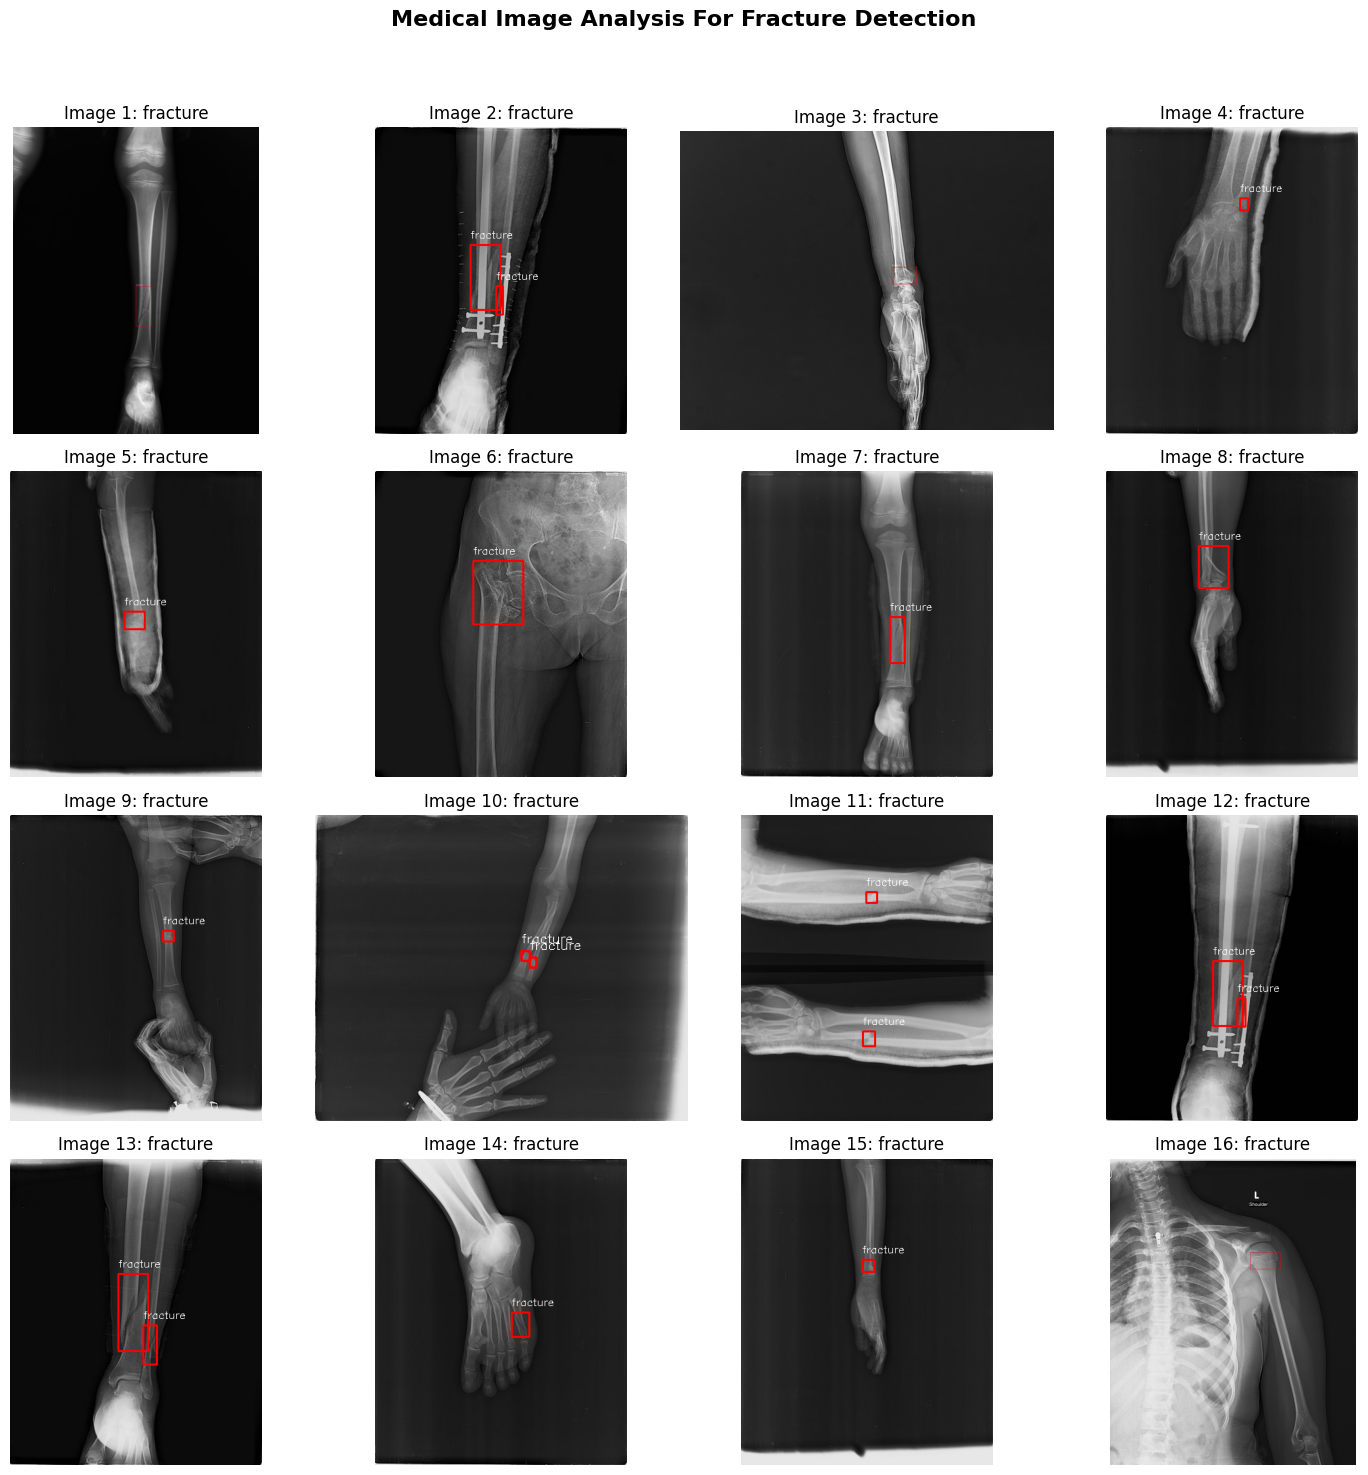

In [11]:
plot_multiple_images_with_rectangles(fracture_image_paths)

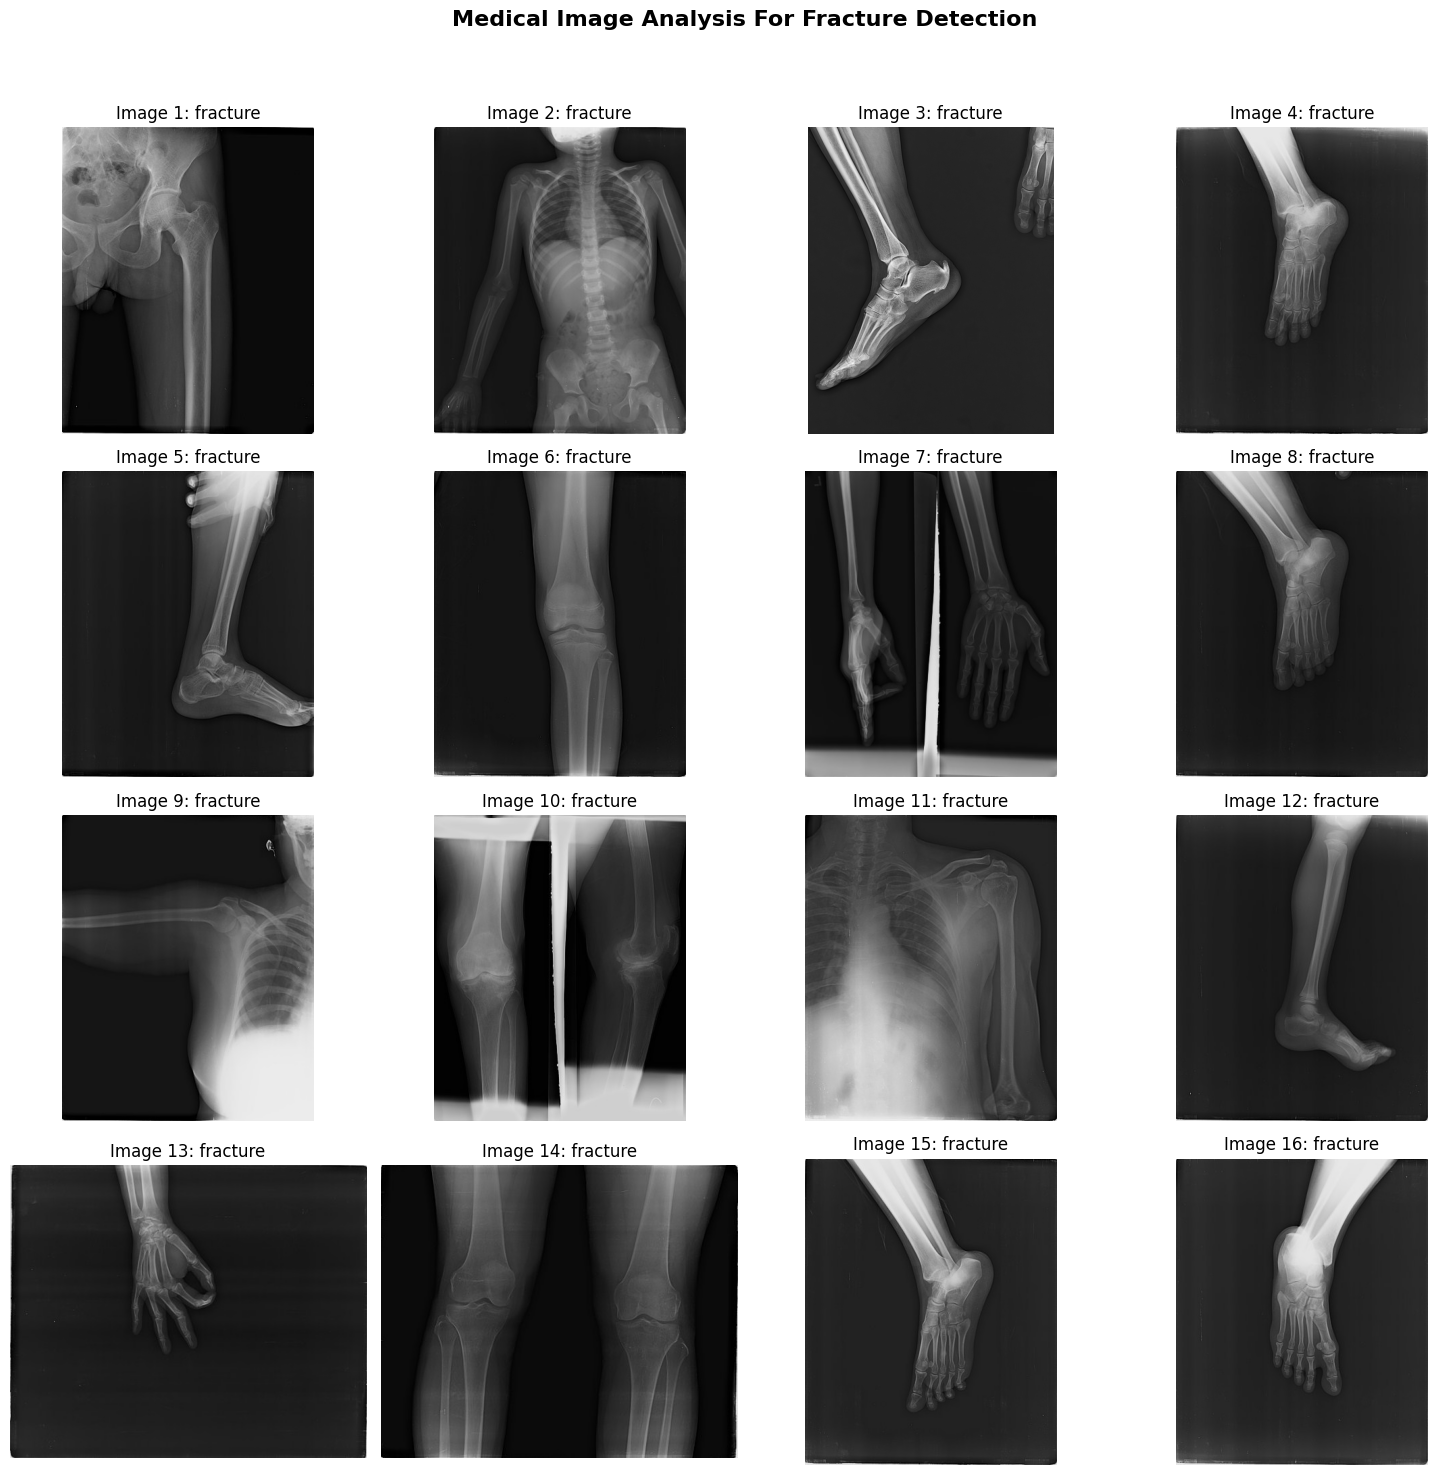

In [12]:
plot_multiple_images_with_rectangles(normal_image_paths)

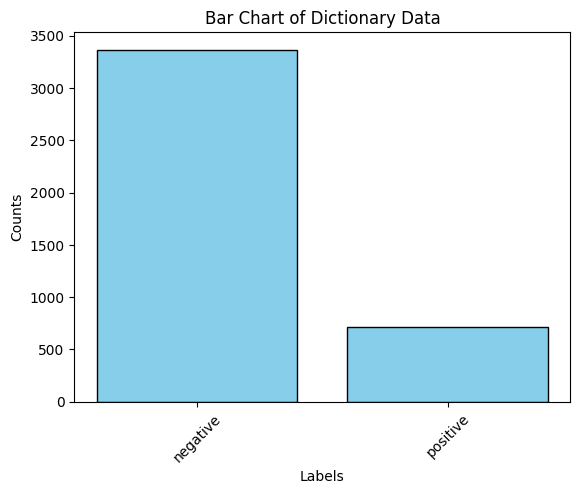

In [13]:
# labels distribution
plt.bar(["negative", "positive"], [len(normal_image_paths), len(fracture_image_paths)],
        color='skyblue',
        edgecolor='black')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(["negative", "positive"], rotation=45)
plt.title('Bar Chart of Dictionary Data')

# Display the chart
plt.show()

## Observation

It seems the training dataset is imbalanced:

| Negative Counts | Positive Counts |
| --------------- | --------------- |
| 14589           | 5912            |

From my observation, the training dataset is imbalanced, with significantly more negative samples (14,589) than positive samples (5,912). This imbalance could cause the model to be biased toward predicting the majority class (negative), which could lead to poor performance in identifying the minority class (positive).

To address this issue, several strategies can be employed:

1. **Resampling Techniques**:
   - **Oversampling**: Increase the number of positive samples by duplicating or generating synthetic data. One popular technique for this is the **SMOTE (Synthetic Minority Over-sampling Technique)** algorithm, which generates synthetic samples by interpolating between existing positive samples.
   - **Undersampling**: Reduce the number of negative samples to match the number of positive samples. While this helps balance the dataset, it may lead to the loss of important information.

2. **Class Weighting**: Many machine learning algorithms, including those in **TensorFlow** and **Scikit-learn**, offer class weights to penalize the model more for incorrect predictions on the minority class. This can be achieved by specifying higher weights for the positive class during model training. This encourages the model to pay more attention to the minority class.

3. **Data Augmentation**: Augmenting the dataset by applying transformations (such as rotations, flips, cropping, etc.) to the positive samples can help generate additional diverse examples, especially if the positive class has fewer variations in features compared to the negative class.

4. **Evaluation Metrics**: In an imbalanced dataset, **accuracy** may not be the best evaluation metric. It's important to monitor metrics like **Precision**, **Recall**, **F1-score**, and **AUC-ROC** to get a better understanding of the model's performance across both classes. In my project, I am working with **imbalanced data** in **object detection** tasks, designing appropriate evaluation metrics becomes crucial to ensure the model's performance on both the majority and minority classes is fairly assessed. Hence I have several options to be considered:
   - **Precision**: Measures how many of the predicted positive bounding boxes are correct. It is the ratio of true positives (TP) to all predicted positives (TP + false positives (FP)).【**Precision = TP / (TP + FP)**】
   - **Recall**: Measures how many of the actual positive bounding boxes were detected. It is the ratio of true positives (TP) to all actual positives (TP + false negatives (FN)).【**Recall = TP / (TP + FN)**】
   - **F1-Score**: This metric is particularly helpful because it penalizes a model that is biased toward one of the metrics (e.g., accuracy or recall), which is common when dealing with imbalanced data.【**F1-score = 2 * (Precision * Recall) / (Precision + Recall)**】
   - **Intersection over Union (IoU)**: **IoU** measures the overlap between the predicted bounding box and the ground truth bounding box. This is essential in object detection tasks to evaluate how accurate the bounding box predictions are. For imbalanced datasets, focusing on a reasonable IoU threshold is important.【**IoU = Area of Overlap / Area of Union**】
   - **Average Precision (AP) and Mean Average Precision (mAP)**: **Average Precision (AP)** is an evaluation metric that considers both precision and recall, and it is computed for each class by plotting the precision-recall curve 【**AP = ∫ (Precision * Recall) d(Recall)**】. **mAP** is the mean of the AP scores across all classes.
   - **Weighted Average Precision (WAP)**: To address class imbalance more effectively, one of all the options is **weighted average precision**, where the AP score for each class is weighted based on the class frequency or importance. This helps in giving more importance to the minority classes that may otherwise be overshadowed by the majority class.【**WAP = Σ (AP_class * class_weight) / total_weight**】

By implementing one or more of these methods, I can ensure that the model performs better on both the negative and positive classes, reducing bias toward the majority class and improving overall classification performance.

# Prepare Training and Label Data

According to the [ultralytics tutorial](https://docs.ultralytics.com/zh/yolov5/tutorials/train_custom_data/#how-do-i-convert-my-annotated-data-to-yolov5-format), and I observe that not all the images are available with their label files. However, I have to create a few paths for custom training like followings:

```bash
Image_path:
YOLODataSet/dataset/images/train
YOLODataSet/dataset/images/val

Label_path:
YOLODataSet/dataset/labels/train
YOLODataSet/dataset/labels/val
```

After that, I also create a `YAML` file as data config file for model training parameters, the following parameters have to be defined in a data config file:

- train, and val: Locations of train, and validation images.
- nc: Number of classes in the dataset.
- names: Names of the classes in the dataset. The index of the classes in this list would be used as an identifier for the class names in the code.

```bash
train: ../Path/to/train/images/
val:  ../Path/to/val/images

nc: Number of classes

names: [class_names...]
```

other source: [1](https://www.digitalocean.com/community/tutorials/train-yolov5-custom-data#convert-the-annotations-into-the-yolo-v5-format), [2](https://docs.ultralytics.com/zh/yolov5/tutorials/train_custom_data/#4-train)

## Create Dataset Folder

In this part I will create all the dataset path for further training.

In [14]:
def create_dataset_path(root_dir: str = ROOT_DIR):
    """
    Create and ensure the existence of dataset directory paths for training and validation images and labels.

    This function generates paths for storing training and validation data (images and labels) within a
    structured directory under the specified root directory. If the directories do not already exist,
    they are created.
    """
    data_dirs = ['images', 'labels']
    split_dirs = ['train', 'val']
    dataset_paths = []

    # Create sub folders
    for data_dir in data_dirs:
        for split_dir in split_dirs:
            dataset_path = root_dir.joinpath(data_dir, split_dir)
            if not dataset_path.exists():
                dataset_path.mkdir(parents=True)
                pass
            dataset_paths.append(dataset_path)

    return dataset_paths

In [15]:
# Create a dataset path
image_train_data_path, image_val_data_path, \
    label_train_data_path, label_val_data_path = create_dataset_path(root_dir=Path('YOLODataSet/FracAtlas_dataset'))

image_train_data_path, image_val_data_path, label_train_data_path, label_val_data_path

(PosixPath('YOLODataSet/FracAtlas_dataset/images/train'),
 PosixPath('YOLODataSet/FracAtlas_dataset/images/val'),
 PosixPath('YOLODataSet/FracAtlas_dataset/labels/train'),
 PosixPath('YOLODataSet/FracAtlas_dataset/labels/val'))

## Process Imbalanced Data

In the previous part I observed that the training dataset is imbalanced, with significantly more negative samples (14,589) than positive samples (5,912). However I decide to employ 2 strategies to figure out:

- For `negative samples`, I would lke to apply **undersampling** technique to reduce the number of negative samples to `10,000` images, this number is enough to fine-tune the `YOLO` model.

- For `positive samples`, I would lke to apply **data augmentation** to augment the dataset by applying `horizontally flips` to the positive samples util `10,000` images. This can help generate additional diverse examples, especially if the positive class has fewer variations in features compared to the negative class.

In [16]:
def flip_image_with_bbox(image_array: np.array, bounding_boxes: tuple) -> tuple:
    """
    Horizontally flip an image and adjust the bounding box coordinates.

    Args:
        image_array (np.array): Numpy array of the input image.
        bbox (tuple): Bounding box coordinates in the format (x_center, y_center, width, height).
    Returns:
        tuple: Flipped image and adjusted bounding box coordinates.
    """
    # Horizontally flip the image
    flipped_image = cv2.flip(image_array, 1)
    new_bboxes = []

    # Get the original bounding box coordinates
    for bounding_box in bounding_boxes:
        x_center, y_center, width, height = bounding_box

        # Calculate the new bounding box coordinates
        new_x_center = round((1. - x_center), 6)
        new_bbox = (new_x_center, y_center, width, height)
        new_bboxes.append(new_bbox)

    return flipped_image, new_bboxes

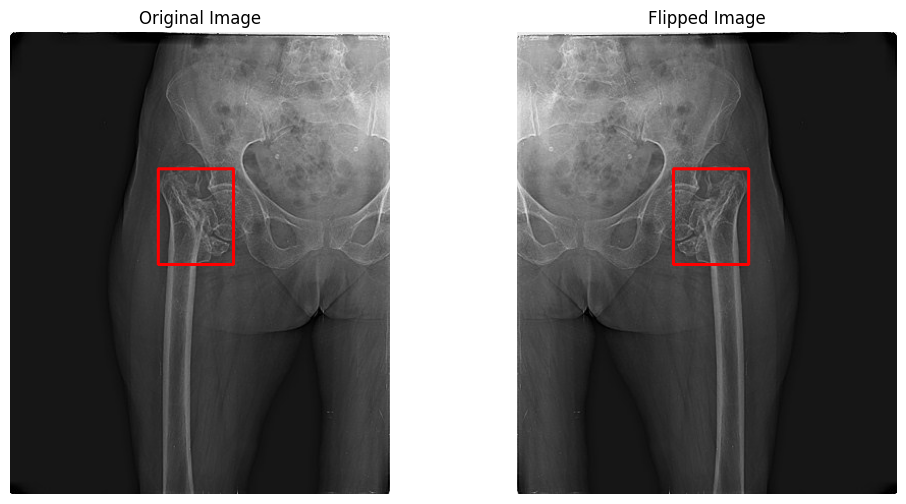

In [17]:
def flip_and_plot_image_with_rectangles(image_path: str):
    """
    Flip an image horizontally and adjust the bounding box coordinates. Also plot the original and flipped images with bounding boxes.

    Args:
        image_path (str): Path to the input image.
    """
    # Read the image using OpenCV
    image = read_image(image_path)
    img_height, img_width, _ = image.shape

    # Read labels of the image
    label_path = generate_label_path(image_path)
    bounding_boxes = read_label(label_path)

    # Plot the original image with the bounding box
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # ===== plot original image ====
    for (x_center, y_center, width, height) in bounding_boxes:
        # Convert bounding box to pixel coordinates
        x_min, y_min, x_max, y_max = calculate_bounding_box(img_height, img_width, x_center, y_center, width, height)

        # Draw the bounding box and center point
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=2)  # Blue box

    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # ===== plot flipped image ====
    # Horizontally flip the image using OpenCV
    flipped_image, new_bounding_boxes = flip_image_with_bbox(image, bounding_boxes=bounding_boxes)
    for (new_x_center, new_y_center, new_width, new_height) in new_bounding_boxes:
        # Convert bounding box to pixel coordinates
        new_x_min, new_y_min, new_x_max, new_y_max = calculate_bounding_box(
            img_height, img_width, new_x_center, new_y_center, new_width, new_height
        )

        # Draw the bounding box and center point
        cv2.rectangle(flipped_image, (new_x_min, new_y_min), (new_x_max, new_y_max), color=(255, 0, 0), thickness=2)  # Blue box

    axs[1].imshow(flipped_image)
    axs[1].set_title('Flipped Image')
    axs[1].axis('off')

    plt.show()

img_selected = random.choice(fracture_image_paths)
flip_and_plot_image_with_rectangles(img_selected)

## Move Images And Labels To Dataset

In this part I will combine the previous functions together to create a pipeline containing:

1. Create a dataset path

2. Sample and read image paths

3. Employ data augmentation

4. Move selected images and labels to the dataset created on step 1

In [18]:
def balance_dataset(fracture_images: List[Path], normal_images: List[Path]) -> Tuple:
    """
    Balance the dataset by downsampling normal images to match the number of fracture images.
    Then copy all selected images to the output folder.

    Parameters:
        fracture_path (str): Path to the folder containing fracture images
        normal_path (str): Path to the folder containing normal images
    Returns:
        Tuple with balanced fractured and normal images
    """
    # Randomly select normal images to match the number of fracture images
    if len(normal_images) > len(fracture_images):
        normal_images = random.sample(normal_images, len(fracture_images))
        print(f"Downsampled normal images to {len(normal_images)}")
    else:
        fracture_images = random.sample(fracture_images, len(normal_images))
        print(f"Downsampled fractured images to {len(normal_images)}")

    return fracture_images, normal_images

def move_image(src_path: Path, dest_path: Path, mode: str='copy'):
    """
    Move or copy an image from the source path to the destination path based on the mode.

    Args:
        src_path (Path): The source path of the image.
        dest_path (Path): The destination directory path.
        mode (str): The mode of operation, either 'copy' to copy the file or any other value to move the file. Default is 'copy'.
    Returns:
        Path: The destination file path of the moved or copied image.
    """
    try:
        # Get the file name and generate the destination path
        dest_file_path = dest_path.joinpath(src_path.name)

        # Move or copy the file based on the mode
        if mode == 'copy':
            shutil.copy(str(src_path), str(dest_file_path))
        else:
            shutil.move(str(src_path), str(dest_file_path))

        return dest_file_path

    except Exception as e:
        print(f"An error occurred: {e}")

class LabelModifier:
    def __init__(self):
        pass

    @staticmethod
    def read_label_file(file_path: Path):
        with open(file_path, 'r') as file:
            return file.readlines()

    @staticmethod
    def create_modified_lines(bbox_lines, label):
        if not bbox_lines:
            modified_lines = ["%s 0.0 0.0 0.0 0.0"%(str(label))]
        else:
            modified_lines = []
            for line in bbox_lines:
                parts = line.strip().split()
                parts[0] = str(label)

                # Ensure each line ends with a newline character
                line_with_break = ' '.join(parts) + '\n'
                modified_lines.append(line_with_break)

        return modified_lines

    @staticmethod
    def write_label_file(file_path, lines):
        with open(file_path, 'w') as file:
            file.writelines(lines)

def move_label(label_path, label, label_dest_file_path):
    original_lines = LabelModifier.read_label_file(label_path)
    modified_lines = LabelModifier.create_modified_lines(original_lines, label)
    LabelModifier.write_label_file(label_dest_file_path, modified_lines)


def augment_image_and_label(image_path, label_path, label, image_dest_path, label_dest_path):
    """
    Create and save augmented versions of an image and its label.

    Args:
        image_path: Path to the original image
        label_path: Path to the original label
        label: The class label (True for 'Fractured')
        image_dest_path: Destination directory for the augmented image
        label_dest_path: Destination directory for the augmented label
    """
    image = read_image(image_path)
    bounding_boxes = read_label(label_path)

    # Create augmented versions (can be expanded to include more augmentations)
    flipped_image, new_bbox = flip_image_with_bbox(image, bounding_boxes)

    # Create new filenames for augmented data
    aug_image_filename = image_dest_path / image_path.with_stem(f"{image_path.stem}_aug").name
    aug_label_filename = label_dest_path / label_path.with_stem(f"{label_path.stem}_aug").name

    # Save augmented image
    cv2.imwrite(filename=str(aug_image_filename), img=flipped_image)

    # Save augmented label
    new_label_lines = LabelModifier.create_modified_lines(bbox_lines=new_bbox, label=label)
    LabelModifier.write_label_file(file_path=aug_label_filename, lines=new_label_lines)


def process_image_set(image_paths, image_dest_path, label_dest_path, do_augmentation, desc_prefix):
    """
    Process a set of images (either training or validation).

    Args:
        image_paths: List of image paths to process
        image_dest_path: Destination path for images
        label_dest_path: Destination path for labels
        do_augmentation: Whether to perform data augmentation
        desc_prefix: Prefix for progress bar description
    """
    for image_path in tqdm(image_paths, ncols=100, desc=f"{desc_prefix} images and labels"):
        label_path = generate_label_path(image_path)
        label = int('Fractured' in str(image_path))

        # move image
        move_image(src_path=image_path, dest_path=image_dest_path, mode='copy')

        # move labels
        move_label(label_path=label_path, label=label, label_dest_file_path=(label_dest_path / label_path.name))

        # move augmented image and label
        if do_augmentation:
            augment_image_and_label(image_path, label_path, label, image_dest_path, label_dest_path)


def move_data_to_dataset(
        image_paths,
        target_data_dir: Path = Path('YOLODataSet/FracAtlas_dataset'),
        val_size: float = 0.1,
        data_aug: bool = False
    ):
    """
    Move and organize image data into training and validation datasets.

    Args:
        image_paths: List of paths to images
        target_data_dir: Root directory for the dataset
        val_size: Proportion of data to use for validation
        data_aug: Whether to perform data augmentation
    """
    # create target dirs
    image_train_data_path, image_val_data_path, \
        label_train_data_path, label_val_data_path = create_dataset_path(root_dir=target_data_dir)

    # Split train and val dataset
    total_num = len(image_paths)
    split_idx = int(total_num * val_size)
    train_images = image_paths[:-split_idx]
    val_images = image_paths[-split_idx:]

    # Process training and validation sets
    process_image_set(train_images, image_train_data_path, label_train_data_path, data_aug, "Training")

    # No augmentation for validation set# No augmentation for validation set
    process_image_set(val_images, image_val_data_path, label_val_data_path, False, "Validation")



In [31]:
if __name__ == '__main__':
    fracture_image_paths, normal_image_paths_balanced = balance_dataset(
        fracture_images=fracture_image_paths,
        normal_images=normal_image_paths
    )
    move_data_to_dataset(fracture_image_paths, target_data_dir=Path('/content/datasets/YOLODataSet/FracAtlas_dataset'))
    move_data_to_dataset(normal_image_paths_balanced, target_data_dir=Path('/content/datasets/YOLODataSet/FracAtlas_dataset'))

Downsampled normal images to 717


Validation images and labels: 100%|█████████████████████████████████| 71/71 [00:19<00:00,  3.57it/s]


In [28]:
# Assuming you want to create a YAML file for YOLOv5 training.
# Replace placeholders with your actual paths and class names.

data_yaml_content = """
train: YOLODataSet/FracAtlas_dataset/images/train/
val: YOLODataSet/FracAtlas_dataset/images/val/

nc: 2  # Number of classes (e.g., Fracture and Normal)
names: ['Normal', 'Fractured']
"""

with open('xr_bones_binary_classes.yaml', 'w') as f:
  f.write(data_yaml_content)

!cat xr_bones_binary_classes.yaml


train: YOLODataSet/FracAtlas_dataset/images/train/
val: YOLODataSet/FracAtlas_dataset/images/val/

nc: 2  # Number of classes (e.g., Fracture and Normal)
names: ['Normal', 'Fractured']


In [40]:

data_yaml_content = """
train: YOLODataSet/FracAtlas_dataset/images/train/
val: YOLODataSet/FracAtlas_dataset/images/val/

nc: 1  # Number of classes (e.g., Fracture and Normal)
names: ['Fractured']
"""

with open('xr_bones.yaml', 'w') as f:
  f.write(data_yaml_content)

!cat xr_bones.yaml


train: YOLODataSet/FracAtlas_dataset/images/train/
val: YOLODataSet/FracAtlas_dataset/images/val/

nc: 1  # Number of classes (e.g., Fracture and Normal)
names: ['Fractured']


## Remove Incorrect Class In Label Files

In [ ]:
# # YOLODataSet
# LABEL_DIR = 'YOLODataSet/dataset/labels'
# LABEL_TRAIN_DIR = Path(LABEL_DIR).joinpath('train')
# LABEL_VALID_DIR = Path(LABEL_DIR).joinpath('val')

# # Remove invalid class information
# for label_dir in [LABEL_TRAIN_DIR, LABEL_VALID_DIR]:
#     for label_path in label_dir.iterdir():
#         with open(label_path, 'r') as file:
#             lines =file.readlines()

#         # Find the labels that greater than 1 lines
#         if len(lines) > 1:
#             valid_line = [lines[0]]

#             # Rewrite correct label in file
#             with open(label_path, 'w') as file:
#                 file.writelines(valid_line)
#                 print(f"Rewrite the valid label {valid_line} into {label_path} successfully.")

# Train YOLO Model

## Binary classification (fracture and normal)

In [20]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [32]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO models
yolov5 = YOLO("yolov5n.pt")

# Display model information (optional)
print(yolov5.info())

# Train the model on the x ray example dataset for 10 epochs
v5_binary_results = yolov5.train(
    data="xr_bones_binary_classes.yaml",
    project='XRayDetection', name='run',
    epochs=30, imgsz=640, device=0, close_mosaic=0
)

PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

YOLOv5n summary: 153 layers, 2,654,816 parameters, 0 gradients, 7.8 GFLOPs
(153, 2654816, 0, 7.840102399999999)
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov5n.pt, data=xr_bones_binary_classes.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=XRayDetection, name=run4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val,

100%|██████████| 755k/755k [00:00<00:00, 21.0MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1760  ultralytics.nn.modules.conv.Conv             [3, 16, 6, 2, 2]              
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      4800  ultralytics.nn.modules.block.C3              [32, 32, 1]                   
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     29184  ultralytics.nn.modules.block.C3              [64, 64, 2]                   
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  3    156928  ultralytics.nn.modules.block.C3              [128, 128, 3]                 
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 89.1MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/YOLODataSet/FracAtlas_dataset/labels/train... 1279 images, 0 backgrounds, 13 corrupt: 100%|██████████| 1292/1292 [00:00<00:00, 2225.24it/s]

train: WARNING ⚠️ /content/datasets/YOLODataSet/FracAtlas_dataset/images/train/IMG0004073.jpg: ignoring corrupt image/label: image file is truncated (3 bytes not processed)
train: WARNING ⚠️ /content/datasets/YOLODataSet/FracAtlas_dataset/images/train/IMG0004097.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/datasets/YOLODataSet/FracAtlas_dataset/images/train/IMG0004120.jpg: ignoring corrupt image/label: image file is truncated (8 bytes not processed)
train: WARNING ⚠️ /content/datasets/YOLODataSet/FracAtlas_dataset/images/train/IMG0004121.jpg: ignoring corrupt image/label: image file is truncated (40 bytes not processed)
train: WARNING ⚠️ /content/datasets/YOLODataSet/FracAtlas_dataset/images/train/IMG0004122.jpg: ignoring corrupt image/label: image file is truncated (26 bytes not processed)
train: WARNING ⚠️ /content/datasets/YOLODataSet/FracAtlas_dataset/images/train/IMG0004142.jpg: ignoring corrupt image/label: image file is truncated (32 bytes not processed)
train

train: New cache created: /content/datasets/YOLODataSet/FracAtlas_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/YOLODataSet/FracAtlas_dataset/labels/val... 142 images, 0 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<00:00, 2288.33it/s]

val: New cache created: /content/datasets/YOLODataSet/FracAtlas_dataset/labels/val.cache


Plotting labels to XRayDetection/run4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to XRayDetection/run4
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.34G      2.798       7.47      1.932         12        640: 100%|██████████| 80/80 [00:33<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

                   all        142        150   0.000298     0.0823   0.000271   7.66e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.73G      2.661        5.2      1.774         15        640: 100%|██████████| 80/80 [00:31<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all        142        150      0.586      0.108     0.0412     0.0136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.74G      2.592      3.857      1.771         14        640: 100%|██████████| 80/80 [00:28<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all        142        150      0.579     0.0696     0.0311    0.00878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.76G      2.619      3.302      1.842         15        640: 100%|██████████| 80/80 [00:28<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all        142        150      0.603      0.133     0.0834     0.0265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.77G      2.557      3.089      1.752         19        640: 100%|██████████| 80/80 [00:28<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]

                   all        142        150      0.137      0.114     0.0787     0.0256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.79G      2.527      2.783      1.727         21        640: 100%|██████████| 80/80 [00:28<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]

                   all        142        150      0.154      0.158      0.105     0.0398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30       2.8G      2.523      2.753      1.672         16        640: 100%|██████████| 80/80 [00:29<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

                   all        142        150      0.254      0.171      0.162     0.0572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.81G      2.391      2.542       1.62         15        640: 100%|██████████| 80/80 [00:28<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

                   all        142        150      0.091       0.12     0.0768     0.0265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.83G      2.315       2.42      1.592         19        640: 100%|██████████| 80/80 [00:28<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

                   all        142        150      0.341      0.136      0.158      0.058



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.84G      2.345      2.443      1.585          9        640: 100%|██████████| 80/80 [00:28<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

                   all        142        150       0.28      0.171      0.169     0.0667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.86G      2.306      2.309      1.588          9        640: 100%|██████████| 80/80 [00:29<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

                   all        142        150      0.148      0.152      0.124      0.047



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.87G      2.284      2.296      1.542         18        640: 100%|██████████| 80/80 [00:28<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        142        150      0.202      0.101      0.106     0.0427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.89G      2.205      2.129      1.505         12        640: 100%|██████████| 80/80 [00:28<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

                   all        142        150      0.254      0.177      0.184     0.0678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30       2.9G      2.252      2.132      1.535         17        640: 100%|██████████| 80/80 [00:28<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        142        150      0.214      0.171      0.158     0.0651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.92G      2.175      2.091      1.486         17        640: 100%|██████████| 80/80 [00:29<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

                   all        142        150      0.419      0.133      0.183     0.0636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.93G      2.175      2.153      1.511         14        640: 100%|██████████| 80/80 [00:28<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        142        150      0.216      0.196      0.177     0.0718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.94G       2.13      2.077      1.495         15        640: 100%|██████████| 80/80 [00:28<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        142        150      0.296      0.165       0.19     0.0845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.96G      2.131      1.956       1.47         18        640: 100%|██████████| 80/80 [00:28<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]

                   all        142        150      0.266      0.177      0.197     0.0785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.97G      2.062      1.921      1.433         12        640: 100%|██████████| 80/80 [00:29<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]

                   all        142        150       0.29      0.174      0.194     0.0829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.99G      2.039      1.888      1.426         17        640: 100%|██████████| 80/80 [00:28<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]

                   all        142        150      0.296      0.203      0.218     0.0956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30         3G      2.001      1.858      1.406         28        640: 100%|██████████| 80/80 [00:28<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

                   all        142        150      0.272      0.203      0.217     0.0953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.02G      2.019      1.832      1.428         10        640: 100%|██████████| 80/80 [00:28<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

                   all        142        150      0.341      0.177      0.221     0.0955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.03G      1.975      1.752       1.38         13        640: 100%|██████████| 80/80 [00:29<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        142        150      0.273      0.259      0.249      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.04G      1.958      1.751      1.382         17        640: 100%|██████████| 80/80 [00:28<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]

                   all        142        150       0.29      0.218      0.233      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.06G       1.96      1.693      1.376         11        640: 100%|██████████| 80/80 [00:28<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]


                   all        142        150      0.255      0.257      0.227      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.07G      1.898      1.711      1.359          8        640: 100%|██████████| 80/80 [00:28<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]

                   all        142        150      0.315      0.203      0.223      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.09G      1.898      1.677      1.338         15        640: 100%|██████████| 80/80 [00:29<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all        142        150      0.254      0.272       0.25      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30       3.1G      1.917      1.594      1.371         23        640: 100%|██████████| 80/80 [00:28<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        142        150      0.296      0.276      0.268      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.12G      1.853      1.592      1.319         13        640: 100%|██████████| 80/80 [00:28<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        142        150       0.31      0.259       0.27      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.13G      1.835      1.563      1.324         10        640: 100%|██████████| 80/80 [00:29<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        142        150      0.308      0.283      0.273      0.126



30 epochs completed in 0.262 hours.
Optimizer stripped from XRayDetection/run4/weights/last.pt, 5.3MB
Optimizer stripped from XRayDetection/run4/weights/best.pt, 5.3MB

Validating XRayDetection/run4/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv5n summary (fused): 84 layers, 2,503,334 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


                   all        142        150      0.308      0.284      0.274      0.126
                Normal         71         71          0          0          0          0
             Fractured         71         79      0.616      0.568      0.548      0.252
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 7.1ms postprocess per image
Results saved to XRayDetection/run4


In [34]:
if IN_COLAB:
    from google.colab import files
    import shutil

    shutil.make_archive('XRayDetection', 'zip', '/content/XRayDetection')
    files.download('XRayDetection.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Only for fracture

In [45]:
# from ultralytics import YOLO

# # Load a COCO-pretrained YOLO models
# yolov5 = YOLO("yolov5n.pt")
# yolov8 = YOLO("yolov8s.pt")

# # Display model information (optional)
# print(yolov5.info())
# print(yolov8.info())

In [44]:
# Train the model on the x ray example dataset for 10 epochs
# v5_results = yolov5.train(
#     data="xr_bones.yaml",
#     project='XRayDetection', name='yolov5_only_for_fracture',
#     epochs=10, imgsz=640, close_mosaic=1
# )

In [46]:
# Train the model on the x ray example dataset for 10 epochs
# v8_results = yolov8.train(
#     data="xr_bones.yaml",
#     project='XRayDetection', name='yolov5_only_for_fracture',
#     epochs=10, imgsz=640, device=0, close_mosaic=1
# )

# End